#### Loading libraries

In [248]:
import numpy as np
import pandas as pd
import scipy as sp
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

#### Loading the dataset

In [249]:
customer_data = pd.read_csv("Telco-Customer-Churn.csv", sep=r'\s*,\s*', engine='python')
customer_data.head()

,customerID,tenure,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,7590-VHVEG,1,29.85,29.85,Female,0,Yes,No,No,No phone service,...,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,5575-GNVDE,34,56.95,1889.50,Male,0,No,No,Yes,No,...,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,3668-QPYBK,2,53.85,108.15,Male,0,No,No,Yes,No,...,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,7795-CFOCW,45,42.30,1840.75,Male,0,No,No,No,No phone service,...,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,9237-HQITU,2,70.70,151.65,Female,0,No,No,Yes,No,...,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


### Data Pre-Processing

In [250]:
customer_data.describe()

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen
count,7043.000000,7043.000000,7032.000000,7043.000000
mean,32.371149,64.761692,2283.300441,0.162147
std,24.559481,30.090047,2266.771362,0.368612
min,0.000000,18.250000,18.800000,0.000000
25%,9.000000,35.500000,401.450000,0.000000
50%,29.000000,70.350000,1397.475000,0.000000
75%,55.000000,89.850000,3794.737500,0.000000
max,72.000000,118.750000,8684.800000,1.000000


In [251]:
#Replacing blanks with 0 for all columns
customer_data.replace('', np.nan, inplace=True)

#As total charges are related with monthly charges
#0 values can negatively affect the analysis 
customer_data=customer_data[customer_data["TotalCharges"].notnull()]

#QC
customer_data.isnull().any()

customerID          False
tenure              False
MonthlyCharges      False
TotalCharges        False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
Churn               False
dtype: bool

In [252]:
#Creating a copy
cust_data=customer_data.copy()
#customer ID
cust_id=customer_data.iloc[:,0]
customer_data=customer_data.drop('customerID',axis=1)

#Target column -churn flag
customer_data['Churn'] = customer_data['Churn'].replace({"Yes":1,"No":0})
cust_churn=customer_data['Churn']
customer_data=customer_data.drop('Churn',axis=1)

#Fixing the data types for quantitative columns
customer_data['TotalCharges']=customer_data['TotalCharges'].astype(float)
customer_data['MonthlyCharges']=customer_data['MonthlyCharges'].astype(float)
customer_data['tenure']=customer_data['tenure'].astype(int)

In [253]:
#Copying columns with numerical values
numerical_col=customer_data[['TotalCharges','MonthlyCharges']]
customer_data=customer_data.drop(numerical_col.columns,axis=1)

In [254]:
#QC
customer_data.head()

,tenure,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,1,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,34,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
3,45,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic)
4,2,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check


In [255]:
list_col=['TechSupport', 'StreamingTV', 'StreamingMovies', 'DeviceProtection', 'OnlineBackup', 'OnlineSecurity']

#Replace 'No internet' with No
for i in list_col:
    customer_data= customer_data.replace({i:'No internet service'},'No')

In [256]:
#tenure - no of months the user has been with the company
customer_data.loc[customer_data['tenure']==customer_data['tenure'].max(),'tenure'].unique()

array([72])

In [257]:
#setting buckets with range of 12 months(1 year) for tenure
tenure_names=['0_12_months','13_24_months','25_36_months','37_48_months','49_60_months','61_72_months']
criteria = {range(1, 13):1, range(13, 25):2, range(25, 37):3, range(37, 49):4, range(49, 61):5, range(61, 73):6}

customer_data['tenure'] = customer_data['tenure'].apply(lambda x: next((v for k, v in criteria.items() if x in k), 0))
customer_data['tenure'].unique()

array([1, 3, 4, 2, 6, 5], dtype=int64)

In [258]:
customer_data.loc[customer_data.tenure==1,'tenure']='0_12_months'
customer_data.loc[customer_data.tenure==2,'tenure']='13_24_months'
customer_data.loc[customer_data.tenure==3,'tenure']='25_36_months'
customer_data.loc[customer_data.tenure==4,'tenure']='37_48_months'
customer_data.loc[customer_data.tenure==5,'tenure']='49_60_months'
customer_data.loc[customer_data.tenure==6,'tenure']='61_72_months'
customer_data['tenure'].unique()

array(['0_12_months', '25_36_months', '37_48_months', '13_24_months',
       '61_72_months', '49_60_months'], dtype=object)

In [259]:
customer_data['gender'] = customer_data['gender'].replace({"Male":1,"Female":0})

In [260]:
customer_data.head()

,tenure,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,0_12_months,0,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,25_36_months,1,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,0_12_months,1,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
3,37_48_months,1,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic)
4,0_12_months,0,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check


#### Binary Label Encoding  
All columns with values 'Yes' and 'No' changed to 1 and 0 respectively

In [261]:
#Making a list of categorical columns
categorical_col=customer_data.dtypes[customer_data.dtypes=='object'].index.tolist()
categorical_df=customer_data[categorical_col]

#Separate lists for binary and multiclass categorical variables
binary_col=categorical_df.nunique()[categorical_df.nunique() == 2].index.tolist()
multiclass_col=categorical_df.nunique()[categorical_df.nunique() > 2].index.tolist()

for i in binary_col:
    categorical_df[i]= categorical_df[i].replace({'Yes':1,'No':0})

C:\Users\japso\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


#### Get dummies 
Convert Multi-class Labels to Dummy variables

In [262]:
#Drop the first one
categorical_df= pd.get_dummies(categorical_df,columns=multiclass_col, prefix_sep='_', drop_first=True)
categorical_df.head()

,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,...,tenure_61_72_months,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
1,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0


In [263]:
categorical_df.columns

Index(['Partner', 'Dependents', 'PhoneService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'PaperlessBilling', 'tenure_13_24_months',
       'tenure_25_36_months', 'tenure_37_48_months', 'tenure_49_60_months',
       'tenure_61_72_months', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

#### Dataset to be used for analysis

In [264]:
#Removing columns which have been processed
treated_cust=customer_data.drop(categorical_col,axis=1)
#customer_data left join categorical variables
treated_cust=treated_cust.merge(right=categorical_df,left_index=True,right_index=True,how='left')
#customer_data left join numerical variables
treated_cust=treated_cust.merge(right=numerical_col,left_index=True,right_index=True,how='left')

#sample view
treated_cust.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalCharges,MonthlyCharges
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,29.85,29.85
1,1,0,0,0,1,1,0,1,0,0,...,0,0,0,1,0,0,0,1,1889.50,56.95
2,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1,108.15,53.85
3,1,0,0,0,0,1,0,1,1,0,...,0,0,0,1,0,0,0,0,1840.75,42.30
4,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,151.65,70.70


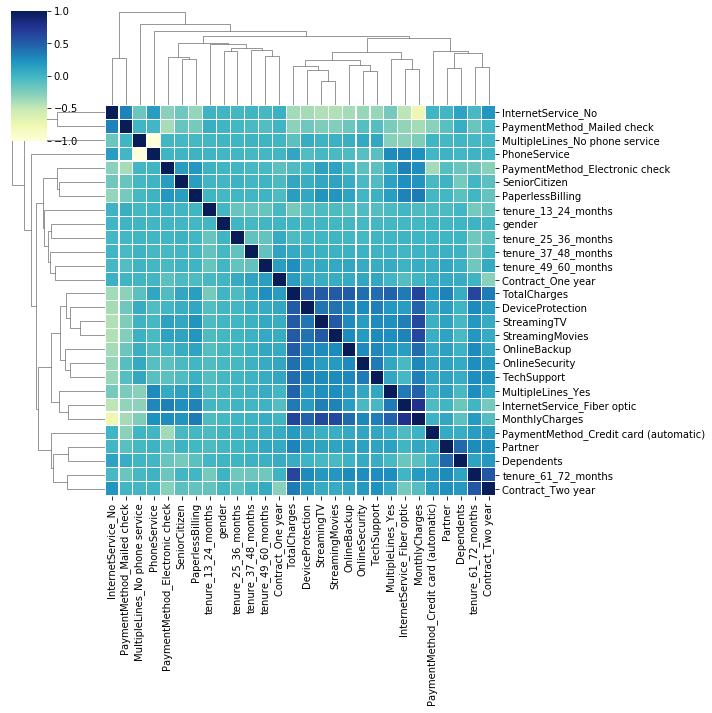

In [265]:
#Creating a grid Correlation Matrix
arr_corr=treated_cust.corr()
cg = sns.clustermap(arr_corr, cmap ="YlGnBu", linewidths = 0.1); 
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0) 
  
cg

#### Splitting the dataset into training set and validation set (80:20) 

In [266]:
X_train,X_test,y_train,y_test=train_test_split(treated_cust,cust_churn, test_size=0.2, random_state=31)

#### Standard Scaling of total charges and Monthly charges 

In [267]:
from sklearn.preprocessing import StandardScaler
sc_X=StandardScaler()
X_train_sc=X_train.copy()
#Normalizing the training set 
X_train_sc[['TotalCharges','MonthlyCharges']]=sc_X.fit_transform(X_train_sc[['TotalCharges','MonthlyCharges']])

X_test_sc=X_test.copy()
X_test_sc[['TotalCharges','MonthlyCharges']]=sc_X.transform(X_test_sc[['TotalCharges','MonthlyCharges']])

### 1. Simple Logistic Regression

In [268]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train_sc, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [269]:
Y_pred = logreg.predict(X_test_sc)

#Testing set accuracy
from sklearn.metrics import accuracy_score
print('accuracy score',accuracy_score(y_test, Y_pred))

#Precision=True positive / (True positive + False positive)
#Recall=True positive / (True positive + False negative)
#F1 is the harmonic mean of precision and recall
from sklearn.metrics import f1_score
print('f1_score',f1_score(y_test, Y_pred))

#F1 is the harmonic mean of precision and recall
from sklearn.metrics import classification_report
print ("\n Classification report : \n",classification_report(y_test,Y_pred))

accuracy score 0.7995735607675906
f1_score 0.5634674922600619

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.66      0.49      0.56       371

    accuracy                           0.80      1407
   macro avg       0.75      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407



#### Confusion Matrix

[[943  93]
 [189 182]]


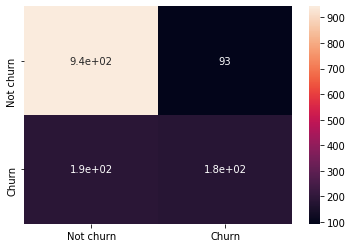

In [270]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Y_pred)
sns.heatmap(cm,xticklabels = ["Not churn","Churn"],yticklabels = ["Not churn","Churn"], annot=True)
print(cm)



#### ROC Curve

Area under curve :  0.7003988489837546 



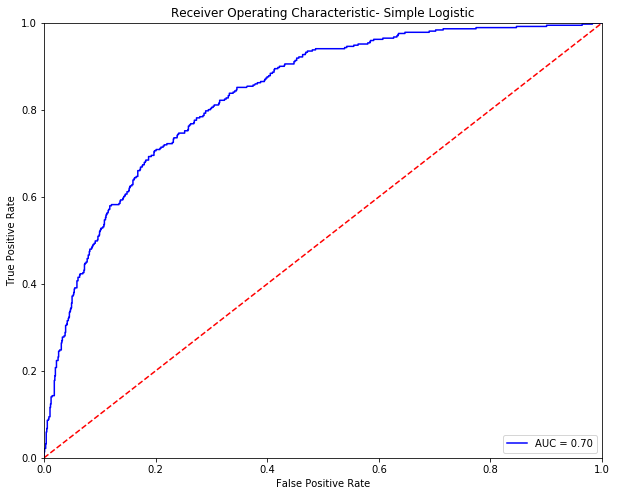

In [271]:
#predicted probabilities
probabilities = logreg.predict_proba(X_test_sc)

from sklearn.metrics import roc_curve,roc_auc_score
#Compute ROC Score
model_roc_auc = roc_auc_score(y_test, Y_pred)
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probabilities[:,1])

plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic- Simple Logistic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % model_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### 2. Regularization Methods
- 2.1 Logistic Regression using GLMNET

In [272]:
#Usage
import glmnet_python
from glmnet import glmnet

import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from glmnet import glmnet; from glmnetPlot import glmnetPlot
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

ModuleNotFoundError: No module named 'glmnet_python'

In [273]:
fit = glmnet(x = X_train_sc.values.astype(scipy.float64), y = y_train.values.astype(scipy.float64), family = 'binomial')

NameError: name 'glmnet' is not defined

#### Couldn't use glmnet on Windows machine 
### 2.2 Hyperparameter Tuning using GridSearch

In [274]:
# Create regularization penalty space
penalty = ['l1', 'l2'] #Lasso,Ridge respectively

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Creating a dictionary of hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [275]:
# Grid search using 5-fold cross validation
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)

In [276]:
# Fit the best model from grid search
best_model = clf.fit(X_train_sc, y_train)

C:\Users\japso\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\japso\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\japso\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation

C:\Users\japso\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\japso\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\japso\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\japso\Anaconda3\lib\site-packages\

In [277]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 59.94842503189409


#### Performance Metrics for GridSearchCV

In [278]:
# Predict target vector
Y_pred = best_model.predict(X_test_sc)

#Testing set accuracy
from sklearn.metrics import accuracy_score
print('accuracy score',accuracy_score(y_test, Y_pred))

#Precision=True positive / (True positive + False positive)
#Recall=True positive / (True positive + False negative)
#F1 is the harmonic mean of precision and recall
from sklearn.metrics import f1_score
print('f1_score',f1_score(y_test, Y_pred))

#F1 is the harmonic mean of precision and recall
from sklearn.metrics import classification_report
print ("\n Classification report : \n",classification_report(y_test,Y_pred))

accuracy score 0.8009950248756219
f1_score 0.56656346749226

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.67      0.49      0.57       371

    accuracy                           0.80      1407
   macro avg       0.75      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407



#### Confusion Matrix

[[944  92]
 [188 183]]


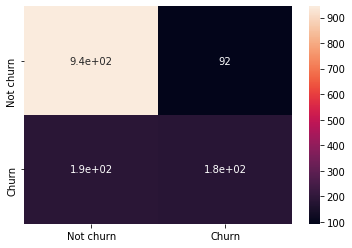

In [279]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Y_pred)
sns.heatmap(cm,xticklabels = ["Not churn","Churn"],yticklabels = ["Not churn","Churn"], annot=True)
print(cm)


#### ROC Curve

Area under curve :  0.7022291833612588 



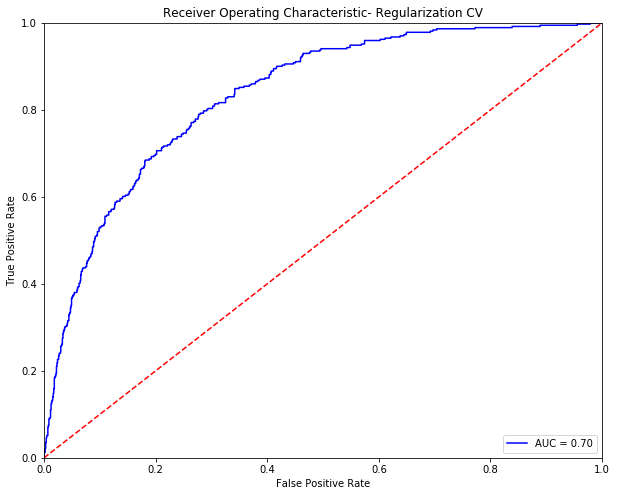

In [280]:
#predicted probabilities
probabilities = best_model.predict_proba(X_test_sc)

from sklearn.metrics import roc_curve,roc_auc_score
#Compute ROC Score
model_roc_auc = roc_auc_score(y_test, Y_pred)
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probabilities[:,1])

plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic- Regularization CV')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % model_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### 3. Feature Selection
RFECV(Recursive Feauture Elimination Cross Validation)

In [281]:
logreg = LogisticRegression(solver='lbfgs')

from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=logreg,  cv=4, scoring='accuracy')
rfecv=rfecv.fit(X_train_sc, y_train)

C:\Users\japso\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [282]:
print('Optimal number of features: {}'.format(rfecv.n_features_))
cols = X_train_sc.columns[rfecv.support_]
Y_pred=rfecv.estimator_.predict(X_test_sc[cols])
acc = accuracy_score(y_test,Y_pred )
print('Number of features selected: {}'.format(rfecv.n_features_))
print('Test Accuracy {}'.format(acc))

Optimal number of features: 22
Number of features selected: 22
Test Accuracy 0.798862828713575


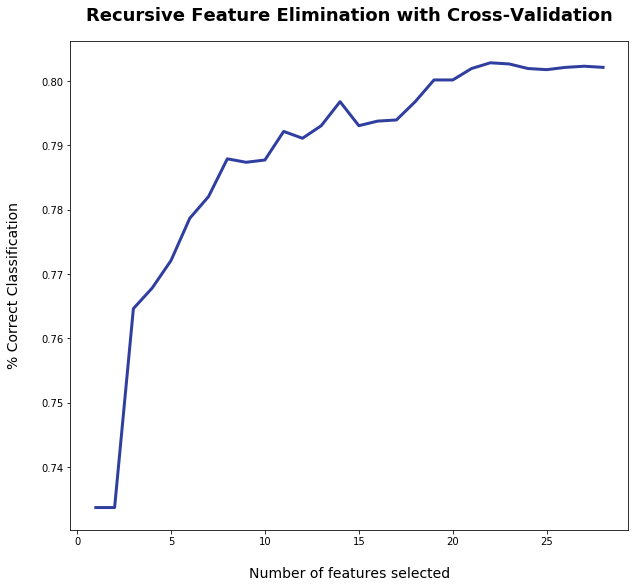

In [283]:
plt.figure(figsize=(10, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

### ****Reminder to add feature importance plot and table

### 4. Dimensionality Reduction
- Principal Component Regression

In [284]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#Starting by PCA
#Using only first 2 principal components
pca=PCA(2)
principal_components = pca.fit_transform(X_train_sc)
pca_data = pd.DataFrame(principal_components,columns = ["PC1","PC2"])
#pca_data = pca_data.merge(cust_churn,left_index=True,right_index=True,how="left")
#pca_data["Churn"] = pca_data["Churn"].replace({1:"Churn",0:"Not Churn"})

In [285]:
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(pca_data, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [286]:
principal_comp_test = pca.transform(X_test_sc)
pca_test = pd.DataFrame(principal_comp_test,columns = ["PC1","PC2"])
Y_pred = logreg.predict(pca_test)

#Testing set accuracy
from sklearn.metrics import accuracy_score
print('accuracy score',accuracy_score(y_test, Y_pred))

#Precision=True positive / (True positive + False positive)
#Recall=True positive / (True positive + False negative)
#F1 is the harmonic mean of precision and recall
from sklearn.metrics import f1_score
print('f1_score',f1_score(y_test, Y_pred))

#F1 is the harmonic mean of precision and recall
from sklearn.metrics import classification_report
print ("\n Classification report : \n",classification_report(y_test,Y_pred))

accuracy score 0.7874911158493249
f1_score 0.5276461295418642

 Classification report : 
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      1036
           1       0.64      0.45      0.53       371

    accuracy                           0.79      1407
   macro avg       0.73      0.68      0.70      1407
weighted avg       0.77      0.79      0.77      1407



[[941  95]
 [204 167]]


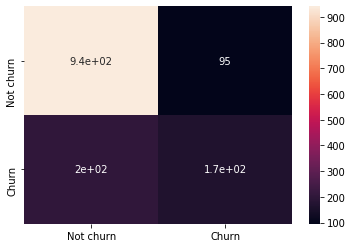

In [287]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Y_pred)
sns.heatmap(cm,xticklabels = ["Not churn","Churn"],yticklabels = ["Not churn","Churn"], annot=True)
print(cm)

Area under curve :  0.6792179645953231 



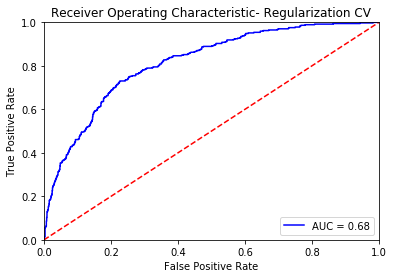

In [288]:
#predicted probabilities
probabilities = logreg.predict_proba(pca_test)

from sklearn.metrics import roc_curve,roc_auc_score
#Compute ROC Score
model_roc_auc = roc_auc_score(y_test, Y_pred)
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probabilities[:,1])

#plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic- Regularization CV')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % model_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Ensemble Methods
- RandomForest

In [289]:
from sklearn.ensemble import RandomForestClassifier
randf = RandomForestClassifier(n_estimators=1000, bootstrap=True,random_state=31)
randf.fit(X_train_sc, y_train)
#RandomForestClassifier(max_depth=2, random_state=0)

# Use the forest's predict method on the test data
Y_pred = randf.predict(X_test_sc)
# Probabilities for each class
Y_pred_probs = randf.predict_proba(X_test_sc)[:, 1]

from sklearn.metrics import classification_report
print ("\n Classification report : \n",classification_report(y_test,Y_pred))


 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.90      0.87      1036
           1       0.64      0.50      0.56       371

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



[[933 103]
 [187 184]]


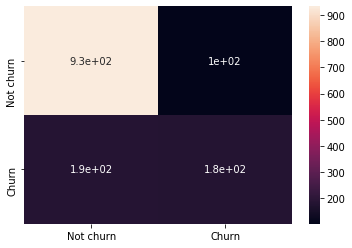

In [290]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Y_pred)
sns.heatmap(cm,xticklabels = ["Not churn","Churn"],yticklabels = ["Not churn","Churn"], annot=True)
print(cm)

Area under curve :  0.6982680119472573 



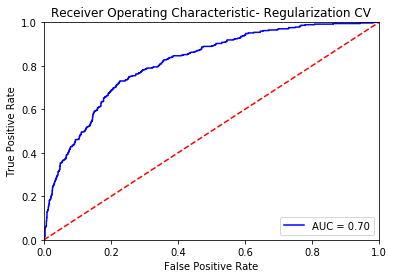

In [291]:
from sklearn.metrics import roc_curve,roc_auc_score
#Compute ROC Score
model_roc_auc = roc_auc_score(y_test, Y_pred)
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probabilities[:,1])

#plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic- Regularization CV')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % model_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

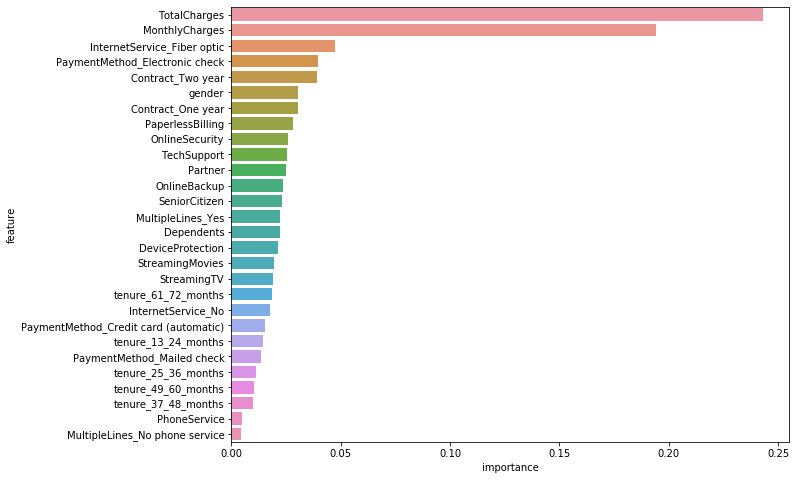

In [292]:
# Extract feature importances
feature_imp = pd.DataFrame({'feature': list(treated_cust.columns),
                   'importance': randf.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
plt.figure(figsize=(10, 8))
ax = sns.barplot(y="feature", x="importance", data=feature_imp)

#### Random Forest Optimization using Random Search
randomly select combinations of hyperparameters from a grid, evaluate them using cross validation on the training data, and return the values that perform the best

In [293]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = 31)

# Create the random search model
randcv = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=31)

# Fit 
randcv.fit(X_train_sc, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   29.7s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [294]:
#parameters of the optimized model
randcv.best_params_

{'n_estimators': 196,
 'min_samples_split': 10,
 'max_leaf_nodes': 46,
 'max_features': 0.5,
 'max_depth': 14,
 'bootstrap': True}

Area under curve :  0.7022291833612588 



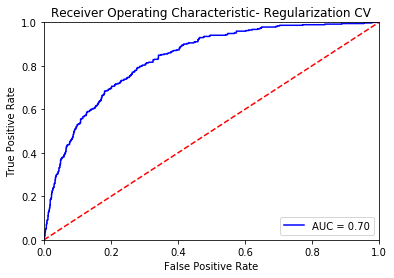


 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.67      0.49      0.57       371

    accuracy                           0.80      1407
   macro avg       0.75      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407



In [295]:
best_forest=randcv.best_params_
train_rf_predictions = best_model.predict(X_train_sc)
train_rf_probs = best_model.predict_proba(X_train_sc)[:, 1]

rf_predictions = best_model.predict(X_test_sc)
rf_probs = best_model.predict_proba(X_test_sc)[:, 1]

from sklearn.metrics import roc_curve,roc_auc_score
#Compute ROC Score
model_roc_auc = roc_auc_score(y_test, rf_predictions)
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,rf_probs)

#plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic- Regularization CV')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % model_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

from sklearn.metrics import classification_report
print ("\n Classification report : \n",classification_report(y_test,rf_predictions))

#### KNN Classification

In [296]:
# Import necessary modules 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, neighbors

In [297]:
# knn clustering

knn = KNeighborsClassifier(n_neighbors= 5) 
  
knn.fit(X_train_sc,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [298]:
# Predict on dataset which model has not seen before 
Z = knn.predict(X_test_sc)
print(knn.predict(X_test_sc))

[0 1 0 ... 0 0 0]


In [299]:
#Calculate the accuracy of the model 
print(knn.score(X_test_sc, y_test))

0.7704335465529495


In [300]:
# Confusion Matrix
print(confusion_matrix(y_test,Z))
print(classification_report(y_test,Z))

[[877 159]
 [164 207]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1036
           1       0.57      0.56      0.56       371

    accuracy                           0.77      1407
   macro avg       0.70      0.70      0.70      1407
weighted avg       0.77      0.77      0.77      1407



In [301]:
# error rate
error_rate = []

for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_sc,y_train)
    pred_i = knn.predict(X_test_sc)
    error_rate.append(np.mean(pred_i != y_test))
    

Text(0, 0.5, 'Error Rate')

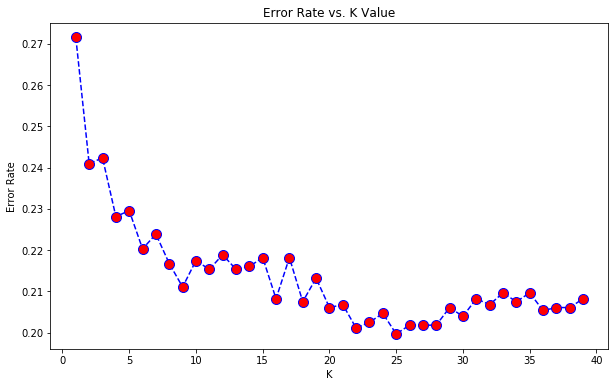

In [302]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [303]:
# k = 25 clusters gives us the lowest error

# knn clustering, with k = 25 clusters 

knn = KNeighborsClassifier(n_neighbors= 25) 
  
knn.fit(X_train_sc, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

In [304]:
# Predict on dataset which model has not seen before 
Z = knn.predict(X_test_sc)
print(Z)

[0 1 0 ... 0 0 0]


In [305]:
#Calculate the accuracy of the model 
print(knn.score(X_test_sc, y_test))

0.8002842928216063


In [306]:
# Confusion Matrix
print(confusion_matrix(y_test,Z))
print(classification_report(y_test,Z))

[[911 125]
 [156 215]]
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1036
           1       0.63      0.58      0.60       371

    accuracy                           0.80      1407
   macro avg       0.74      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



In [307]:
print(knn.fit(X_train_sc, y_train))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')


### k means clustering

In [308]:
from sklearn.cluster import KMeans

# k means clustering

kmeans = KMeans(n_clusters= 3)
kmeans.fit(treated_cust)
y_kmeans = kmeans.predict(treated_cust)

In [309]:
kmeans.cluster_centers_

array([[ 5.01200192e-01,  1.28660586e-01,  3.76140182e-01,
         2.85165627e-01,  8.91262602e-01,  1.44023044e-01,
         1.58665386e-01,  1.53144503e-01,  1.40902544e-01,
         1.94911186e-01,  1.95391263e-01,  5.26644263e-01,
         2.26596255e-01,  8.97743639e-02,  5.30484878e-02,
         4.24867979e-02,  6.60105617e-02,  1.08737398e-01,
         2.69803169e-01,  3.14210274e-01,  3.64378301e-01,
         1.45943351e-01,  1.65626500e-01,  1.64186270e-01,
         3.46375420e-01,  3.24531925e-01,  6.88070319e+02,
         4.97673308e+01],
       [ 5.17690875e-01,  2.07324643e-01,  5.56797020e-01,
         3.03538175e-01,  8.60335196e-01,  4.29546865e-01,
         5.10242086e-01,  5.21415270e-01,  4.35754190e-01,
         5.45003104e-01,  5.53072626e-01,  6.71632526e-01,
         4.96585971e-02,  2.84295469e-01,  3.10986965e-01,
         2.11669770e-01,  1.43389199e-01,  1.39664804e-01,
         4.97827436e-01,  5.09000621e-01,  1.24146493e-03,
         3.01675978e-01,  2.14

In [310]:
k_cluster = kmeans.labels_
print(k_cluster)

clusters_df = pd.DataFrame(k_cluster)

[0 0 0 ... 0 0 2]


In [311]:
# np.isnan(k_cluster)

print(k_cluster)
print(len(y_kmeans))

[0 0 0 ... 0 0 2]
7032


In [312]:
X_clusters = treated_cust.copy()
X_clusters['clusters'] = k_cluster

In [313]:
len(X_clusters)

7032

In [314]:
X_clusters.head(10)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalCharges,MonthlyCharges,clusters
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,29.85,29.85,0
1,1,0,0,0,1,1,0,1,0,0,...,0,0,1,0,0,0,1,1889.50,56.95,0
2,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,1,108.15,53.85,0
3,1,0,0,0,0,1,0,1,1,0,...,0,0,1,0,0,0,0,1840.75,42.30,0
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,151.65,70.70,0
5,0,0,0,0,1,0,0,1,0,1,...,1,0,0,0,0,1,0,820.50,99.65,0
6,1,0,0,1,1,0,1,0,0,1,...,1,0,0,0,1,0,0,1949.40,89.10,0
7,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,301.90,29.75,0
8,0,0,1,0,1,0,0,1,1,1,...,1,0,0,0,0,1,0,3046.05,104.80,1
9,1,0,0,1,1,1,1,0,0,0,...,0,0,1,0,0,0,0,3487.95,56.15,1


#### Running logistic regression taking cluster into account

In [315]:
# Splitting X_clusters into test and train

X_train_c,X_test_c,y_train,y_test =train_test_split(X_clusters,cust_churn, test_size=0.2, random_state=31)


In [316]:
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train_c, y_train)

C:\Users\japso\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [317]:
Y_pred = logreg.predict(X_test_c)

#Testing set accuracy
from sklearn.metrics import accuracy_score
print('accuracy score',accuracy_score(y_test, Y_pred))

#Precision=True positive / (True positive + False positive)
#Recall=True positive / (True positive + False negative)
#F1 is the harmonic mean of precision and recall
from sklearn.metrics import f1_score
print('f1_score',f1_score(y_test, Y_pred))

#F1 is the harmonic mean of precision and recall
from sklearn.metrics import classification_report
print ("\n Classification report : \n",classification_report(y_test,Y_pred))

accuracy score 0.7995735607675906
f1_score 0.562111801242236

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.66      0.49      0.56       371

    accuracy                           0.80      1407
   macro avg       0.75      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407



[[944  92]
 [190 181]]


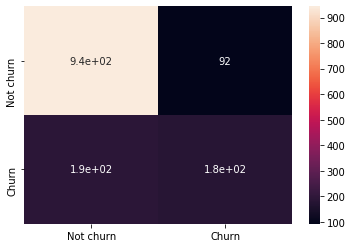

In [318]:
#Confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Y_pred)
sns.heatmap(cm,xticklabels = ["Not churn","Churn"],yticklabels = ["Not churn","Churn"], annot=True)
print(cm)

Area under curve :  0.6995337655715014 



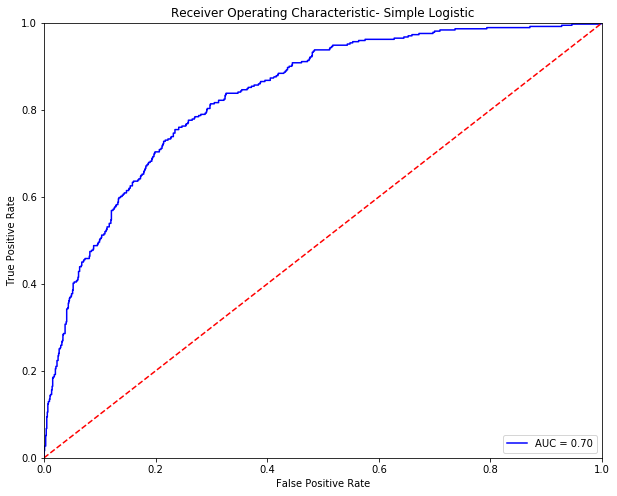

In [319]:
#predicted probabilities
probabilities = logreg.predict_proba(X_test_c)

from sklearn.metrics import roc_curve,roc_auc_score
#Compute ROC Score
model_roc_auc = roc_auc_score(y_test, Y_pred)
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probabilities[:,1])

plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic- Simple Logistic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % model_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Running Logistic Regression for each of the 3 clusters

In [320]:
# Appending customer churn to X_clusters dataset

churn_df = pd.DataFrame(cust_churn)

cluster_churn = X_clusters.copy()
cluster_churn['churn'] = churn_df
cluster_churn.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalCharges,MonthlyCharges,clusters,churn
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,29.85,29.85,0,0
1,1,0,0,0,1,1,0,1,0,0,...,0,1,0,0,0,1,1889.50,56.95,0,0
2,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,1,108.15,53.85,0,1
3,1,0,0,0,0,1,0,1,1,0,...,0,1,0,0,0,0,1840.75,42.30,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,151.65,70.70,0,1


### Logreg for customers in cluster 0

In [321]:
cluster_0 = cluster_churn[cluster_churn['clusters']==0]
cluster_0.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalCharges,MonthlyCharges,clusters,churn
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,29.85,29.85,0,0
1,1,0,0,0,1,1,0,1,0,0,...,0,1,0,0,0,1,1889.50,56.95,0,0
2,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,1,108.15,53.85,0,1
3,1,0,0,0,0,1,0,1,1,0,...,0,1,0,0,0,0,1840.75,42.30,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,151.65,70.70,0,1


In [322]:
# Split cluster_0 into test and train

X_train_0,X_test_0,y_train_0,y_test_0=train_test_split(cluster_0.iloc[:,0:19],cluster_0.iloc[:,20:21], test_size=0.2, random_state=31)

In [323]:
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train_0, y_train_0)

C:\Users\japso\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [324]:
Y_pred_0 = logreg.predict(X_test_0)

#Testing set accuracy
from sklearn.metrics import accuracy_score
print('accuracy score',accuracy_score(y_test_0, Y_pred_0))

from sklearn.metrics import f1_score
print('f1_score',f1_score(y_test_0, Y_pred_0))

from sklearn.metrics import classification_report
print ("\n Classification report : \n",classification_report(y_test_0,Y_pred_0))

accuracy score 0.9015606242496998
f1_score 0.871875

 Classification report : 
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       521
           1       0.85      0.89      0.87       312

    accuracy                           0.90       833
   macro avg       0.89      0.90      0.90       833
weighted avg       0.90      0.90      0.90       833



[[472  49]
 [ 33 279]]


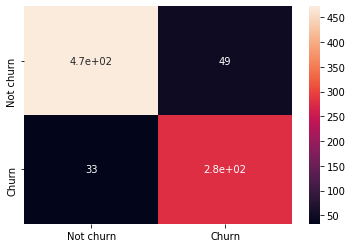

In [325]:
cm = confusion_matrix(y_test_0, Y_pred_0)
sns.heatmap(cm,xticklabels = ["Not churn","Churn"],yticklabels = ["Not churn","Churn"], annot=True)
print(cm)

Area under curve :  0.9000904326000296 



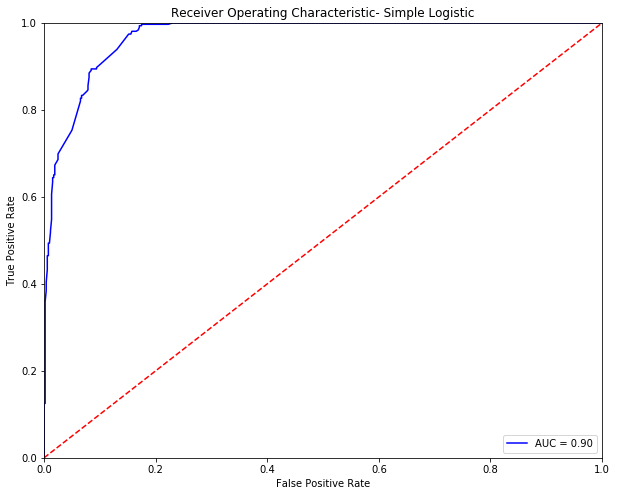

In [326]:
#predicted probabilities
probabilities = logreg.predict_proba(X_test_0)

from sklearn.metrics import roc_curve,roc_auc_score
#Compute ROC Score
model_roc_auc = roc_auc_score(y_test_0, Y_pred_0)
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test_0,probabilities[:,1])

plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic- Simple Logistic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % model_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Logreg for customers in cluster 1

In [327]:
cluster_1 = cluster_churn[cluster_churn['clusters']==1]
cluster_1.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalCharges,MonthlyCharges,clusters,churn
8,0,0,1,0,1,0,0,1,1,1,...,0,0,0,0,1,0,3046.05,104.80,1,1
9,1,0,0,1,1,1,1,0,0,0,...,0,1,0,0,0,0,3487.95,56.15,1,0
14,1,0,0,0,1,1,0,1,1,1,...,0,0,0,0,1,0,2686.05,105.50,1,0
23,0,0,1,0,1,0,1,0,1,0,...,0,0,1,1,0,0,3505.10,59.90,1,0
24,1,0,1,1,1,1,1,0,1,0,...,0,0,0,1,0,0,2970.30,59.60,1,0


In [328]:
# Split cluster_1 into test and train

X_train_1,X_test_1,y_train_1,y_test_1=train_test_split(cluster_1.iloc[:,0:19],cluster_1.iloc[:,20:21], test_size=0.2, random_state=31)

In [329]:
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train_1, y_train_1)

C:\Users\japso\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [330]:
Y_pred_1 = logreg.predict(X_test_1)

#Testing set accuracy
from sklearn.metrics import accuracy_score
print('accuracy score',accuracy_score(y_test_1, Y_pred_1))

from sklearn.metrics import f1_score
print('f1_score',f1_score(y_test_1, Y_pred_1))

from sklearn.metrics import classification_report
print ("\n Classification report : \n",classification_report(y_test_1,Y_pred_1))

accuracy score 0.9969040247678018
f1_score 0.0

 Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       322
           1       0.00      0.00      0.00         1

    accuracy                           1.00       323
   macro avg       0.50      0.50      0.50       323
weighted avg       0.99      1.00      1.00       323



C:\Users\japso\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[322   0]
 [  1   0]]


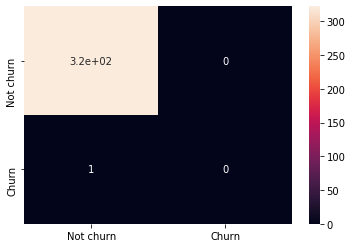

In [331]:
cm = confusion_matrix(y_test_1, Y_pred_1)
sns.heatmap(cm,xticklabels = ["Not churn","Churn"],yticklabels = ["Not churn","Churn"], annot=True)
print(cm)

Area under curve :  0.5 



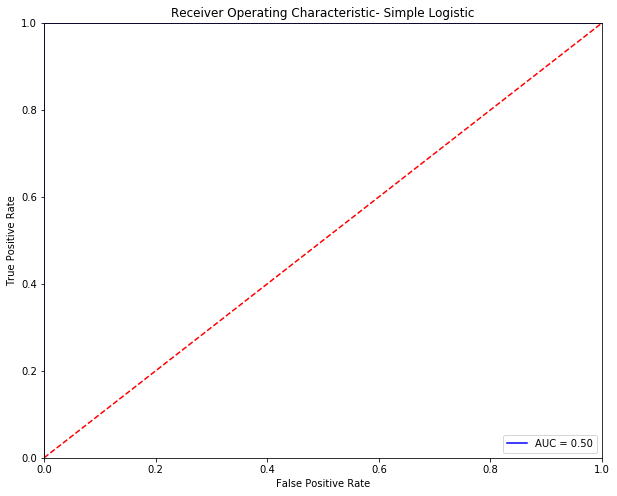

In [332]:
#predicted probabilities
probabilities = logreg.predict_proba(X_test_1)

from sklearn.metrics import roc_curve,roc_auc_score
#Compute ROC Score
model_roc_auc = roc_auc_score(y_test_1, Y_pred_1)
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test_1,probabilities[:,1])

plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic- Simple Logistic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % model_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Logreg for customers in cluster 2

In [333]:
cluster_2 = cluster_churn[cluster_churn['clusters']==2]
cluster_2.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalCharges,MonthlyCharges,clusters,churn
12,1,0,1,0,1,0,0,1,0,1,...,0,1,0,1,0,0,5681.10,100.35,2,0
13,1,0,0,0,1,0,1,1,0,1,...,0,0,0,0,0,0,5036.30,103.70,2,1
15,0,0,1,1,1,1,1,1,1,1,...,0,0,1,1,0,0,7895.15,113.25,2,0
17,1,0,0,1,1,1,0,1,0,1,...,0,0,1,0,0,0,7382.25,106.70,2,0
28,1,0,1,0,1,1,1,1,1,1,...,0,0,1,1,0,0,6369.45,90.25,2,0


In [334]:
# Split cluster_2 into test and train

X_train_2,X_test_2,y_train_2,y_test_2=train_test_split(cluster_2.iloc[:,0:19],cluster_2.iloc[:,20:21], test_size=0.2, random_state=31)

In [335]:
# We cannot perform logistic regression here, since none of the customers in cluster 2 churned.

logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train_2, y_train_2)

C:\Users\japso\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [336]:
cluster_0.describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalCharges,MonthlyCharges,clusters,churn
count,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,...,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,4165.0,4165.000000
mean,0.501321,0.128691,0.375990,0.284994,0.891236,0.144058,0.158703,0.152941,0.140696,0.194718,...,0.364466,0.145738,0.165666,0.164226,0.346218,0.324610,687.758896,49.763794,0.0,0.321008
std,0.500058,0.334898,0.484436,0.451466,0.311380,0.351190,0.365443,0.359974,0.347750,0.396031,...,0.481338,0.352886,0.371825,0.370525,0.475821,0.468285,573.438799,27.158532,0.0,0.466920
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.800000,18.250000,0.0,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,161.650000,20.550000,0.0,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,537.350000,48.700000,0.0,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1144.600000,74.700000,0.0,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1983.150000,112.950000,0.0,1.000000


In [337]:
cluster_1.describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalCharges,MonthlyCharges,clusters,churn
count,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,...,1612.000000,1612.000000,1612.00000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.0,1612.000000
mean,0.517370,0.207196,0.557072,0.303970,0.860422,0.429280,0.509926,0.521712,0.436104,0.545285,...,0.001241,0.302109,0.21464,0.260546,0.348015,0.116005,3280.360205,77.810701,1.0,0.222705
std,0.499853,0.405423,0.496886,0.460113,0.346656,0.495127,0.500057,0.499683,0.496054,0.498100,...,0.035213,0.459315,0.41070,0.439069,0.476489,0.320330,814.669932,17.990792,0.0,0.416191
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1985.150000,26.000000,1.0,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2553.612500,63.887500,1.0,0.000000
50%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,3218.700000,79.325000,1.0,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,0.00000,1.000000,1.000000,0.000000,3974.950000,93.212500,1.0,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,4786.150000,116.250000,1.0,1.000000


In [338]:
cluster_2.describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalCharges,MonthlyCharges,clusters,churn
count,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,...,1255.0,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.0,1255.000000
mean,0.499602,0.216733,0.740239,0.336255,0.998406,0.576096,0.750598,0.749004,0.598406,0.807171,...,0.0,0.301195,0.517131,0.332271,0.288446,0.051793,6297.778685,97.979243,2.0,0.137849
std,0.500199,0.412183,0.438678,0.472616,0.039904,0.494373,0.432840,0.433759,0.490416,0.394677,...,0.0,0.458960,0.499906,0.471215,0.453220,0.221697,1001.345310,11.825757,0.0,0.344878
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4793.800000,64.750000,2.0,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5478.075000,89.550000,2.0,0.000000
50%,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,6151.900000,99.900000,2.0,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,0.000000,7044.175000,107.375000,2.0,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,8684.800000,118.750000,2.0,1.000000


In [339]:
cluster_0.to_csv('cluster_0.csv') 
cluster_1.to_csv('cluster_1.csv') 
cluster_2.to_csv('cluster_2.csv') 